In [1]:
#  Import Libraries
import tensorflow as tf
import matplotlib.pyplot as plt
import kagglehub
import os

In [2]:
# Download Dataset and Define Paths
path = kagglehub.dataset_download("antoreepjana/animals-detection-images-dataset")

# Define the path to the training images
train_path = os.path.join(path, 'train')

print(f"Dataset located at: {train_path}")

Dataset located at: C:\Users\Vaibhav\.cache\kagglehub\datasets\antoreepjana\animals-detection-images-dataset\versions\7\train


In [3]:
# Define image and batch parameters
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
VALIDATION_SPLIT = 0.2

# Load training & validation datasets from the directory
train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
    train_path,
    validation_split=VALIDATION_SPLIT,
    subset="both",
    seed=1337,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
)

class_names = train_ds.class_names
print(f"Found {len(class_names)} classes.")

Found 22566 files belonging to 80 classes.
Using 18053 files for training.
Using 4513 files for validation.
Found 80 classes.


In [4]:
# Define a sequential model for data augmentation
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip("horizontal"),
  tf.keras.layers.RandomRotation(0.2),
  tf.keras.layers.RandomZoom(0.2),
])

In [5]:
# Optimize performance with prefetching
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [6]:
# Load pre-trained MobileNetV2 base
base_model = tf.keras.applications.MobileNetV2(
    input_shape=IMG_SIZE + (3,),
    include_top=False,
    weights='imagenet'
)

# Freeze base model weights
base_model.trainable = False

# Build the final model
inputs = tf.keras.Input(shape=IMG_SIZE + (3,))
x = data_augmentation(inputs)
x = tf.keras.applications.mobilenet_v2.preprocess_input(x)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(len(class_names), activation='softmax')(x)
model = tf.keras.Model(inputs, outputs)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                             

In [7]:
# Compile the model
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

In [8]:
# Train the model
EPOCHS = 10
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
)

Epoch 1/10
565/565 [==============================] - 392s 656ms/step - loss: 1.6175 - accuracy: 0.5933 - val_loss: 0.7904 - val_accuracy: 0.7749
Epoch 2/10
565/565 [==============================] - 338s 597ms/step - loss: 1.0225 - accuracy: 0.7077 - val_loss: 0.7455 - val_accuracy: 0.7780
Epoch 3/10
565/565 [==============================] - 333s 588ms/step - loss: 0.9553 - accuracy: 0.7214 - val_loss: 0.7407 - val_accuracy: 0.7820
Epoch 4/10
565/565 [==============================] - 333s 588ms/step - loss: 0.8980 - accuracy: 0.7364 - val_loss: 0.7357 - val_accuracy: 0.7840
Epoch 5/10
565/565 [==============================] - 343s 605ms/step - loss: 0.8676 - accuracy: 0.7457 - val_loss: 0.7326 - val_accuracy: 0.7853
Epoch 6/10
565/565 [==============================] - 354s 625ms/step - loss: 0.8305 - accuracy: 0.7489 - val_loss: 0.7260 - val_accuracy: 0.7875
Epoch 7/10
565/565 [==============================] - 353s 622ms/step - loss: 0.8147 - accuracy: 0.7534 - val_loss: 0.7327 -

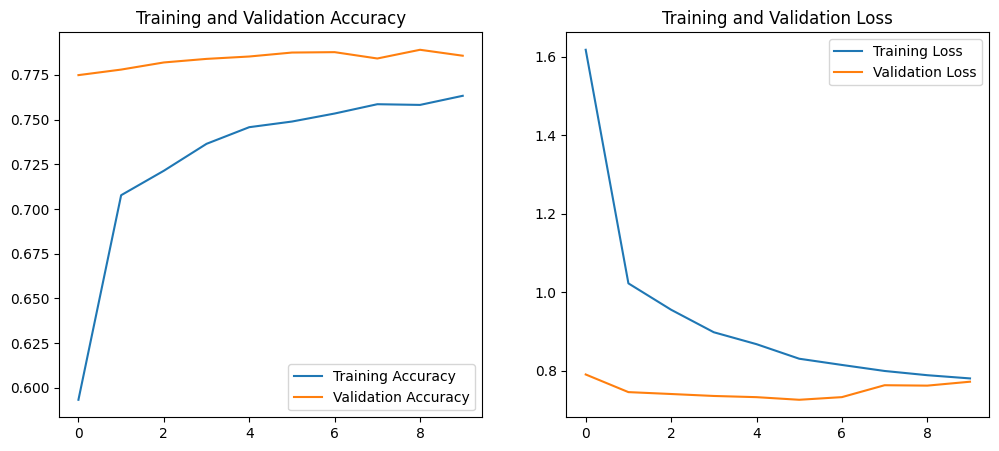

In [9]:
# Plot training & validation accuracy and loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(EPOCHS)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

1/1 [==============================] - 0s 100ms/step


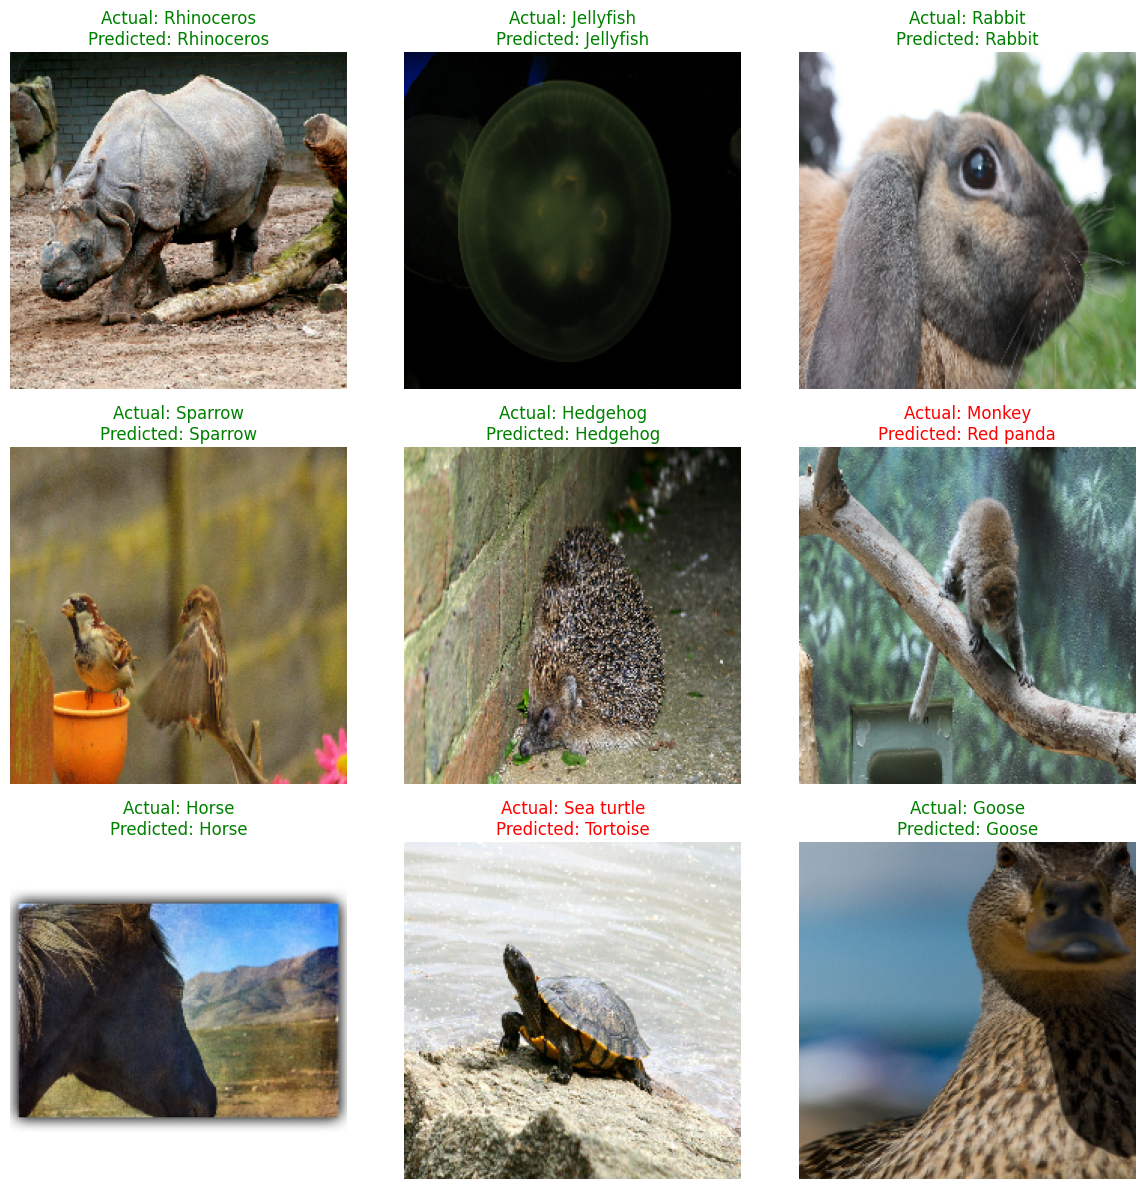

In [12]:
# Cell 10: Make and Visualize Predictions
import numpy as np
import matplotlib.pyplot as plt

image_batch, label_batch = next(iter(val_ds))

predictions = model.predict(image_batch)

plt.figure(figsize=(12, 12))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    
    # --- Prediction Logic ---
    # Find the index of the class with the highest probability score
    predicted_class_index = np.argmax(predictions[i])
    predicted_class = class_names[predicted_class_index]
    
    # Get the actual class name from the label batch
    actual_class = class_names[label_batch[i].numpy()]

    # Set the title color to green for correct predictions, red for incorrect
    title_color = 'green' if predicted_class == actual_class else 'red'

    plt.title(f"Actual: {actual_class}\nPredicted: {predicted_class}", color=title_color)
    plt.axis("off")

plt.tight_layout()
plt.show()